# GRU model

## Setup

In [1]:
# !pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.5/26.5 MB 60.5 MB/s eta 0:00:00:00:0100:01


In [37]:
# import nltk
# nltk.download("stopwords")

In [1]:
import pandas as pd
import numpy as np

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.layers import Masking, GRU, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder


import gensim.downloader as api
from nltk.corpus import stopwords

2024-05-12 15:53:58.001680: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-12 15:54:02.776770: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2024-05-12 15:54:02.778191: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/loca

In [2]:
X = pd.read_csv("../processed_data/features_1000sample_400min_600cutoff_for_embed.csv")
y = pd.read_csv("../processed_data/target_1000sample_400min_600cutoff_for_embed.csv")

In [3]:
codes = {p: i for i, p in enumerate(y["party"].unique())}
# y = y["party"].map(codes)
y = OneHotEncoder(sparse_output=False).fit_transform(y["party"].values.reshape(-1, 1))
X = X["text"]

In [4]:
X.shape, y.shape

((7000,), (7000, 7))

## Preprocessing

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Embed the training and test sentences

In [6]:
stop_words = set(stopwords.words('english'))

# Function to convert a sentence (list of words) into a matrix representing the words in the embedding space
def embed_sentence_with_TF(word2vec, sentence):
    embedded_sentence = []
    for word in sentence:
        if word in word2vec and word not in stop_words:
            embedded_sentence.append(word2vec[word])
        
    return np.array(embedded_sentence)

# Function that converts a list of sentences into a list of matrices
def embedding(word2vec, sentences):
    embed = []
    
    for sentence in sentences:
        embedded_sentence = embed_sentence_with_TF(word2vec, sentence.split())
        embed.append(embedded_sentence)
        
    return embed

In [7]:
word2vec_model = api.load("glove-wiki-gigaword-100")

In [8]:
X_train_embed = embedding(word2vec_model, X_train)
X_test_embed = embedding(word2vec_model, X_test)

### Pad sequences to ensure uniform input size

In [9]:
maxlen = max(max([len(x) for x in X_train_embed]), max([len(x) for x in X_test_embed])) # Maximum sequence length
maxlen

407

In [10]:
X_train_pad = pad_sequences(X_train_embed, dtype='float32', padding='post', maxlen=maxlen)
X_test_pad = pad_sequences(X_test_embed, dtype='float32', padding='post', maxlen=maxlen)

### Tokenize the text data

In [11]:
# tokenizer = Tokenizer(num_words=10000)  # Limit vocabulary size
# tokenizer.fit_on_texts(X_train)
# X_train_seq = tokenizer.texts_to_sequences(X_train)
# X_test_seq = tokenizer.texts_to_sequences(X_test)

## The model

In [24]:
# # Convert words to Word2Vec embeddings
# word_index = tokenizer.word_index
# embedding_matrix = np.zeros((len(word_index) + 1, 300))  # Assuming Word2Vec vectors are 300-dimensional

# for word, i in word_index.items():
#     if word in word2vec_model:
#         embedding_matrix[i] = word2vec_model[word]

# # Define the model
# embedding_layer = tf.keras.layers.Embedding(len(word_index) + 1,
#                                             300,  # Assuming Word2Vec vectors are 300-dimensional
#                                             weights=[embedding_matrix],
#                                             input_length=maxlen,
#                                             trainable=False)  # Freeze the embedding layer

In [12]:
# Define the model
# 51.14%
model = Sequential()
model.add(Masking())
model.add(GRU(128, activation="tanh", return_sequences=True))
model.add(GRU(128, activation="tanh", dropout=0.2, recurrent_dropout=0.4,
              kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.4))
model.add(Dense(7, activation="softmax"))

# Compile the model
my_adam = Adam(learning_rate=0.003)
model.compile(optimizer=my_adam, loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping
es = EarlyStopping(patience=5, restore_best_weights=True, monitor="val_accuracy", mode="max", verbose=1)

2024-05-12 09:35:59.266389: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2024-05-12 09:35:59.267546: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2024-05-12 09:35:59.267607: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (polclass-instance-2): /proc/driver/nvidia/version does not exist
2024-05-12 09:35:59.269144: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with 

In [13]:
# Define the model
# 53.12%
model = Sequential()
model.add(Masking())
model.add(GRU(128, activation="tanh", dropout=0.2, return_sequences=True))
model.add(GRU(128, activation="tanh", dropout=0.2, recurrent_dropout=0.4,
              kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.4))
model.add(Dense(7, activation="softmax"))

# Compile the model
my_adam = Adam(learning_rate=0.003)
model.compile(optimizer=my_adam, loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping
es = EarlyStopping(patience=5, restore_best_weights=True, monitor="val_accuracy", mode="max", verbose=1)

In [14]:
# Define the model
# 52.41%
model = Sequential()
model.add(Masking())
model.add(GRU(128, activation="tanh", return_sequences=True))
model.add(GRU(128, activation="tanh", dropout=0.2, recurrent_dropout=0.4,
              kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.4))
model.add(Dense(7, activation="softmax"))

# Compile the model
my_adam = Adam(learning_rate=0.003)
model.compile(optimizer=my_adam, loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping
es = EarlyStopping(patience=15, restore_best_weights=True, monitor="val_accuracy", mode="max", verbose=1)

In [16]:
# Define the model
# 52.95%
model = Sequential()
model.add(Masking())
model.add(GRU(200, activation="tanh", return_sequences=True))
model.add(GRU(200, activation="tanh", dropout=0.2, recurrent_dropout=0.4,
              kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.4))
model.add(Dense(64, activation="relu"))
# model.add(Dropout(0.2))
model.add(Dense(7, activation="softmax"))

# Compile the model
my_adam = Adam(learning_rate=0.003)
model.compile(optimizer=my_adam, loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping
es = EarlyStopping(patience=5, restore_best_weights=True, monitor="val_accuracy", mode="max", verbose=1)

In [20]:
# Define the model
# 53.75%
model = Sequential()
model.add(Masking())
model.add(GRU(200, activation="tanh", return_sequences=True))
model.add(GRU(150, activation="tanh", dropout=0.4, recurrent_dropout=0.4,
              kernel_regularizer=regularizers.l2(0.015)))
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.4))
model.add(Dense(64, activation="relu"))
# model.add(Dropout(0.2))
model.add(Dense(7, activation="softmax"))

# Compile the model
my_adam = Adam(learning_rate=0.003)
model.compile(optimizer=my_adam, loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping
es = EarlyStopping(patience=5, restore_best_weights=True, monitor="val_accuracy", mode="max", verbose=1)

In [13]:
# Define the model
# %
model = Sequential()
model.add(Masking())
model.add(GRU(150, activation="tanh", return_sequences=True))
model.add(GRU(150, activation="tanh", dropout=0.2,
              kernel_regularizer=regularizers.l2(0.015)))
model.add(Dense(75, activation="relu"))
model.add(Dropout(0.4))
# model.add(Dense(64, activation="relu"))
# model.add(Dropout(0.2))
model.add(Dense(7, activation="softmax"))

# Compile the model
my_adam = Adam(learning_rate=0.0005)
model.compile(optimizer=my_adam, loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping
es = EarlyStopping(patience=5, restore_best_weights=True, monitor="val_accuracy", mode="max", verbose=1)

In [14]:
# Train the model
history = model.fit(
    np.array(X_train_pad), np.array(y_train), epochs=100, batch_size=32, 
    validation_split=0.2, callbacks=[es], shuffle=True)

Epoch 1/100
140/140 [==============================] - 117s 786ms/step - loss: 3.5324 - accuracy: 0.1645 - val_loss: 2.5007 - val_accuracy: 0.2179
Epoch 2/100
140/140 [==============================] - 109s 781ms/step - loss: 2.1868 - accuracy: 0.2217 - val_loss: 1.9351 - val_accuracy: 0.2384
Epoch 3/100
140/140 [==============================] - 110s 789ms/step - loss: 1.9028 - accuracy: 0.2529 - val_loss: 1.7793 - val_accuracy: 0.2679
Epoch 4/100
140/140 [==============================] - 110s 788ms/step - loss: 1.7440 - accuracy: 0.2846 - val_loss: 1.9753 - val_accuracy: 0.2179
Epoch 5/100
140/140 [==============================] - 109s 781ms/step - loss: 1.7915 - accuracy: 0.2714 - val_loss: 1.5944 - val_accuracy: 0.3339
Epoch 6/100
140/140 [==============================] - 109s 782ms/step - loss: 1.6014 - accuracy: 0.3467 - val_loss: 1.5392 - val_accuracy: 0.3714
Epoch 7/100
140/140 [==============================] - 109s 776ms/step - loss: 1.4922 - accuracy: 0.3895 - val_loss: 1

In [60]:
# # Evaluate the model
# loss, accuracy = model.evaluate(X_test_pad, y_test)
# print(f'Test Accuracy: {accuracy*100:.2f}%')

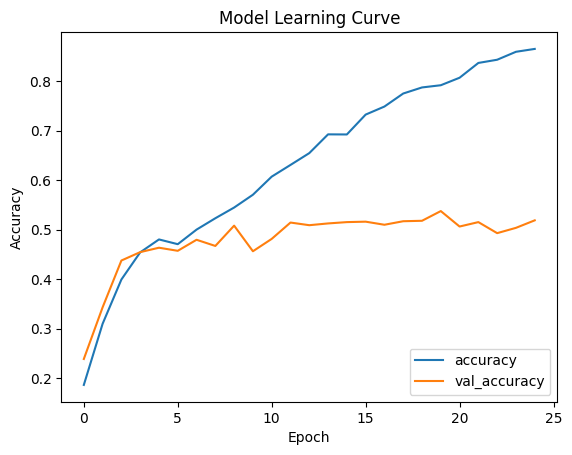

In [23]:
import matplotlib.pyplot as plt

def plot_learning_curve(history):
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Model Learning Curve')
    plt.legend(loc='lower right')
    plt.show()

plot_learning_curve(history)

In [ ]:
from polclassifier.ml_logic import %load_ext